## SNR
The SNR-ratio can be defined by the following function:
\begin{equation}
    SNR = \frac{1}{2\sqrt{2}}\cdot A \cdot \varepsilon  \cdot \Phi  \cdot V_{12}^2  \cdot \sqrt{\frac{T}{\Delta t}}
\end{equation}
where 
\begin{align}
    A &: \text{effective area in [m$^2$]} i.e.  \\
    \varepsilon &: \text{efficiency (detector, optical, filter and polarization multiplied)  [unitless]} \\
    \Phi &: \text{spectral photon flux in [photons m$^{−2}$ s$^{−1}$ Hz$^{−1}$] derived from apparent magnitude (in QUASAR slides corresponds to $F_\nu / h \nu $)}\\
    V_{12} &: \text{visibility [unitless]} \\
    T &: \text{observation or integration time in [s] or [hrs]} \\
    \Delta t &: \text{time resolution in [s]}
\end{align}
The factor of $\frac{1}{\sqrt{2}}$ accounts for the asymmetric start and stop while the $\frac{1}{2}$ accounts for half of the light reaching each SPAD.

In [177]:
import numpy as np
from scipy.constants import c, h
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [178]:
def Phi(mag, wavelength):
    """Determine Phi (spectral photon flux density) as a function of magnitude and wavelength"""
    if mag is not None:
        nu = c / wavelength
        return 10 ** (-22.44 - mag / 2.5) / (2 * nu * h)
    else:
        return None

In [179]:
# for the simple SNR
V_12 = 0.5
diameter = 0.5 # m
delta_t = 3e-11 # s, time resolution
wavelength = 519e-9 # m

efficiency_o_set = 0.8

# including the width of filter for the count rate and random coincidences
delta_lambda = 1e-9 # m

#efficiency_overall = 0.1


In [180]:
# calculating areas:
def area(diameter, secondary_mirror_diameter=0):
    return np.pi*((diameter/2)**2 - (secondary_mirror_diameter/2)**2)#m^2

In [181]:
def SNR_simple(T, magnitude, diameter, efficiency_o = efficiency_o_set, efficiency_d=0.4, efficiency_f=0.9, efficiency_p=1):
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    return (1/(2*np.sqrt(2)))*V_12**2*efficiency_overall*area(diameter)*Phi(magnitude, wavelength)*np.sqrt(T*3600/delta_t) # T multiplied by factor 3600 to have SNR after an hour

print('SNR after one hours: ', SNR_simple(1, 0, 0.5))

SNR after one hours:  2.596980243919622


For two telescopes of different diameters, efficiencies, background flux and time resolution we have:
\begin{align}
    SNR &=  \frac{1}{\sqrt{2}} \cdot |V_{12}|^2 \cdot \varepsilon \cdot \sqrt{\frac{A_1A_2}{(1+B_1/\Phi)(1+B_2/\Phi)}}\cdot \Phi \cdot
    \sqrt{\frac{T}{\sqrt{\Delta t_1\Delta t_2}}} \cdot \sqrt{N_\text{chan}}
\end{align}
where $\varepsilon$ again contains detector, optical, filter and polarization efficiencies of both detectors. In case it differs for the the two telescopes, one takes the geometric mean for each efficiency.

In [182]:
B_1 = 0
B_2 = 0

delta_t_1 = delta_t
delta_t_2 = delta_t

N_channel = 1


def SNR_two(T, magnitude, diameter1, diameter2, efficiency_d=0.4, efficiency_f=0.9, efficiency_p_1=1, efficiency_p_2=1, efficiency_o_1=1, efficiency_o_2=1):
    efficiency_p = np.sqrt(efficiency_p_1*efficiency_p_2)
    efficiency_o = np.sqrt(efficiency_o_1*efficiency_o_2)
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    Phi_ = Phi(magnitude, wavelength)
    area_ = np.sqrt(area(diameter1)*area(diameter2))/((1+B_1/Phi_)*(1+B_2/Phi_))
    return (1/np.sqrt(2))*V_12**2*area_*Phi_*np.sqrt(T*3600/np.sqrt(delta_t_1*delta_t_2))*efficiency_overall*np.sqrt(N_channel)

print('SNR: ', SNR_two(1, 0, 1, 0.5))

SNR:  12.984901219598108


We can also check the source count per second:
\begin{equation}
    N_\text{count} = \frac{1}{2\sqrt{2}} \cdot \varepsilon \cdot \Phi \cdot \Delta \nu \cdot A
\end{equation}
with
\begin{equation}
    \Delta \nu = \frac{c \cdot \Delta \lambda}{\lambda^2}
\end{equation}
The same factor of $\frac{1}{2\sqrt{2}}$ as for the SNR needs to be included.

In [183]:
# when splitting the light into two SPADs
def count_rate(mag, diameter, efficiency_o = efficiency_o_set, efficiency_d=0.4, efficiency_f=0.9, efficiency_p=1):
    Phi_ = Phi(mag, wavelength)
    delta_nu = c*delta_lambda/(wavelength**2)
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    return (1/(2*np.sqrt(2)))*efficiency_overall*delta_nu*Phi_*area(diameter)

print('count rate: ', count_rate(0, 0.5))

count rate:  1055416.7961410459


In [184]:
# for SII with non-zero baseline
def count_rate2(mag, diameter_1, efficiency_o = efficiency_o_set, efficiency_d=0.4, efficiency_f=0.9, efficiency_p=1):
    Phi_ = Phi(mag, wavelength)
    delta_nu = c*delta_lambda/(wavelength**2)
    efficiency_overall = efficiency_o*efficiency_d*efficiency_f*efficiency_p
    return (1/np.sqrt(2))*efficiency_overall*delta_nu*Phi_*area(diameter_1)

## Random Coincidence Count
The random coincidence count (in other words, the baseline) per $\Delta t$ is:
\begin{equation}
    N_\text{random, per \Delta t} &= 2 \cdot \left(\frac{1}{2} \cdot N_\text{count}\right)^2 \cdot \Delta t^2
\end{equation}
The factor 0.5 comes from splitting the beam into two (one for SPAD, one for CCD). \
So random coincidence count per second is:
\begin{equation}
    N_\text{random, per s} &= 2 \cdot \left(\frac{1}{2} \cdot N_\text{count}\right)^2 \cdot \Delta t
\end{equation}

In [185]:
def coincidences_per_bin(magnitude, diameter):
    return 2*((count_rate(magnitude, diameter)/2)**2)*delta_t**2

def coincidences_per_s(T, magnitude, diameter):
    return 2*((count_rate(magnitude, diameter)/2)**2)*delta_t*T


print('random coincidences', coincidences_per_s(1, 0, 0.5))

random coincidences 16.708569203649446


## SNR for different diameter Telescopes and for different magnitudes of stars

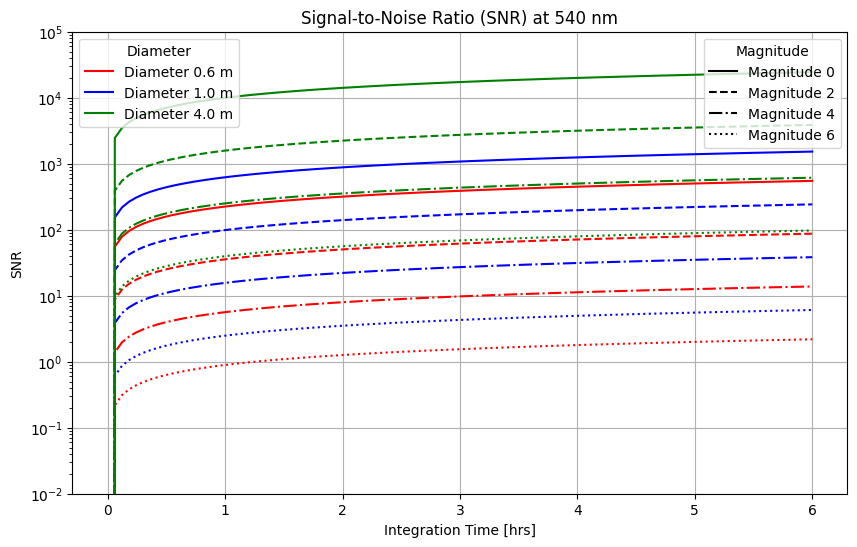

In [186]:
plt.style.use('default')
T_0 = np.linspace(0, 6, 100)
diameters = [0.6, 1.0, 4.0]
magnitudes = [0, 2, 4, 6]

# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 6))

colors = ['r', 'b', 'g']  # Different colors for different diameters
linestyles = ['-', '--', '-.', ':']  # Different linestyles for different magnitudes


for i, diameter in enumerate(diameters):
    for j, magnitude in enumerate(magnitudes):
        snr_values = [SNR_simple(t * 3600, magnitude, diameter) for t in T_0]
        plt.plot(T_0, snr_values, color=colors[i], linestyle=linestyles[j], 
                 label=f'Diameter {diameter} m, Mag {magnitude}')
        
plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) at 540 nm')
diameter_legends = [mlines.Line2D([], [], color=colors[i], linestyle='-', label=f'Diameter {d} m')
                    for i, d in enumerate(diameters)]
magnitude_legends = [mlines.Line2D([], [], color='black', linestyle=linestyles[i], label=f'Magnitude {m}')
                     for i, m in enumerate(magnitudes)]

legend1 = plt.legend(handles=diameter_legends, loc='upper left', title="Diameter")
plt.gca().add_artist(legend1)  # Add the first legend manually
plt.legend(handles=magnitude_legends, loc='upper right', title="Magnitude")
plt.yscale("log")
plt.ylim(1e-2, 1e5)

plt.grid(True)
plt.show()

## SNR for 0.5m Telescope for different magnitudes of stars

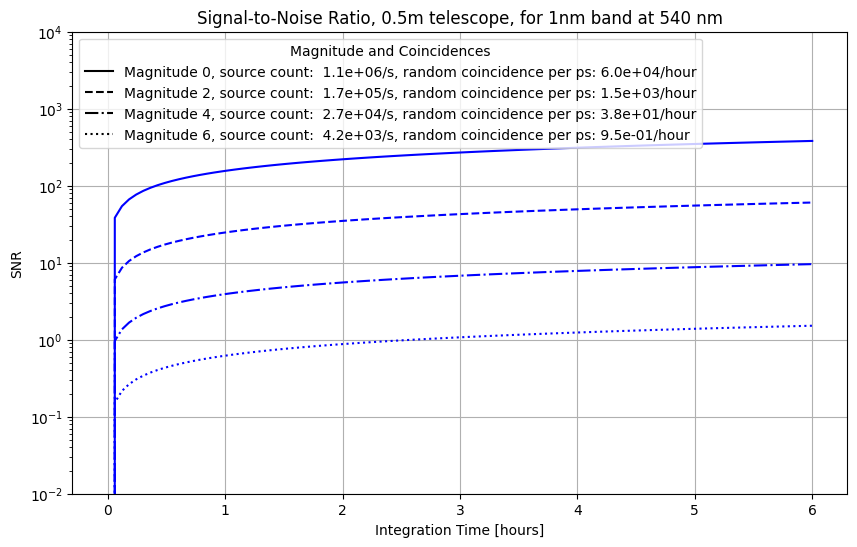

In [187]:
plt.style.use('default')
T_0 = np.linspace(0, 6, 100)
magnitudes = [0, 2, 4, 6]

plt.figure(figsize=(10, 6))

colors = ['r', 'b', 'g']  # Different colors for different diameters
linestyles = ['-', '--', '-.', ':']  # Different linestyles for different magnitudes

legend_entries = []
diameter = 0.5
for j, magnitude in enumerate(magnitudes):
    snr_values = [SNR_simple(t * 3600, magnitude, diameter) for t in T_0]
    plt.plot(T_0, snr_values, color='b', linestyle=linestyles[j], 
                 label=f'Diameter {diameter} m, Mag {magnitude}')
    coinc = coincidences_per_s(3600, magnitude, diameter)
    sourcec = count_rate(magnitude, diameter)
    legend_entries.append(mlines.Line2D([], [], color='black', linestyle=linestyles[j],
                                        label=f'Magnitude {magnitude}, source count:  {sourcec:.1e}/s, random coincidence per ps: {coinc:.1e}/hour'))
    
plt.xlabel('Integration Time [hours]')
plt.ylim(1e-2, 1e4)
plt.ylabel('SNR')
plt.title(f'Signal-to-Noise Ratio, {diameter}m telescope, for 1nm band at 540 nm')



plt.legend(handles=legend_entries, loc='upper left', title="Magnitude and Coincidences")
plt.yscale("log")

plt.grid(True)
plt.show()

In [188]:
# determine after how many seconds until the number of random coincidences has reached a million
def rand_coincidences1M(diameter, magnitude):
    return 1e6/(2*((count_rate(magnitude, diameter)/2)**2)*delta_t)

## Integration Time in Hours as a Function of Telescope Diameter

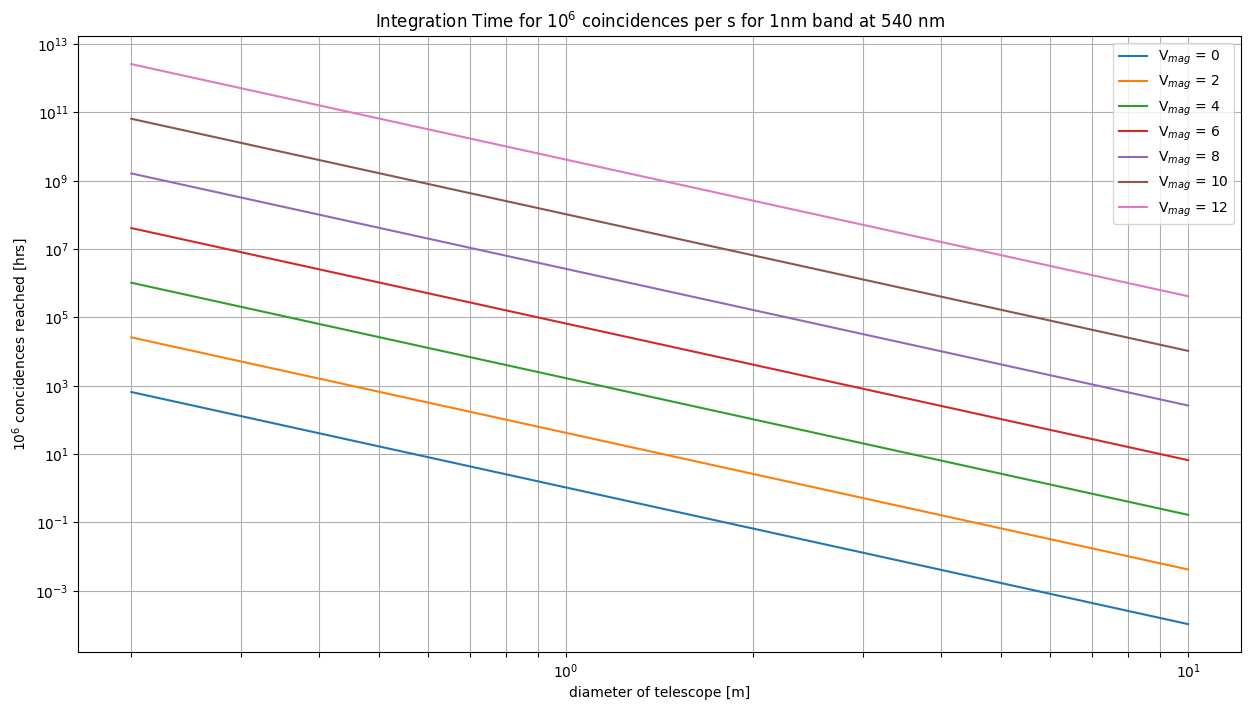

In [189]:
plt.figure(figsize=(15, 8))

magnitudes1 = [0, 2, 4, 6, 8, 10, 12]
diameters = np.linspace(0.2, 10, 100)
for index, mag in enumerate(magnitudes1):
    plt.plot(diameters, rand_coincidences1M(diameters, mag)/3600, label=f'V$_{{mag}}$ = {mag}')
plt.xlabel('diameter of telescope [m]')
plt.ylabel('10$^6$ concidences reached [hrs]')
plt.title('Integration Time for 10$^6$ coincidences per s for 1nm band at 540 nm')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)

from matplotlib.ticker import LogLocator

# Custom tick setting for the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=15))  # More dense ticks


## Integration Time in Nights as a Function of Telescope Diameter

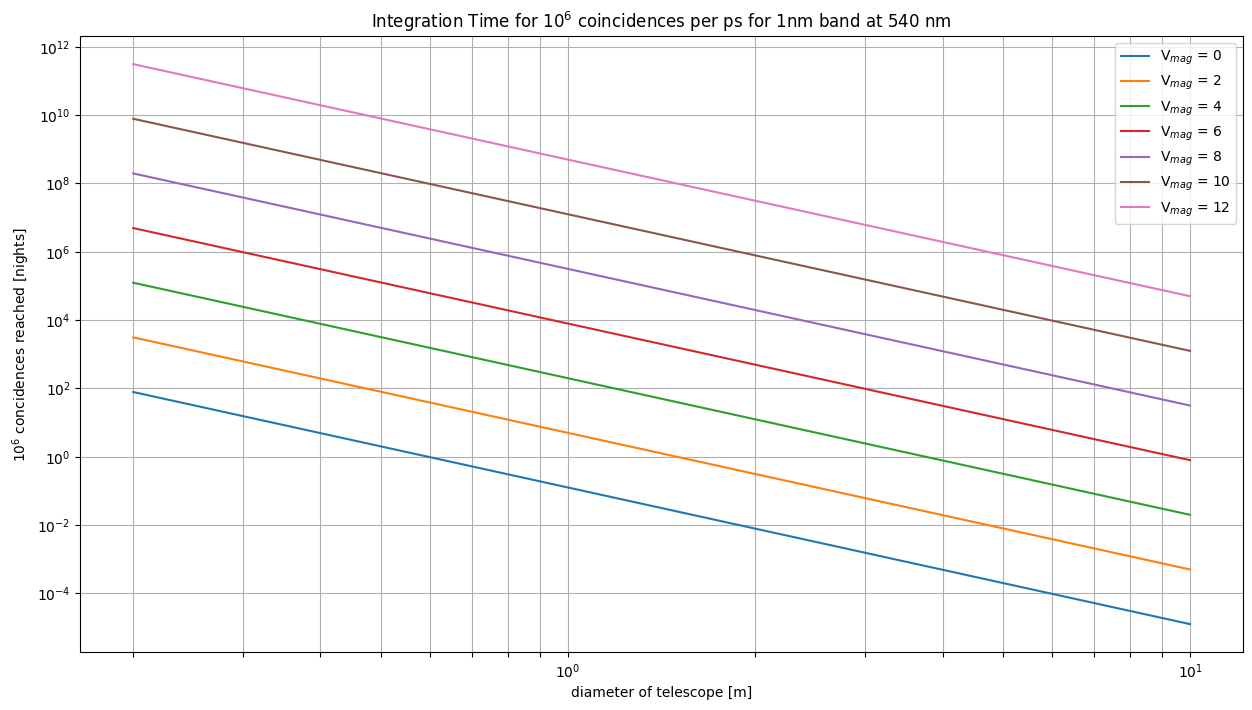

In [190]:
plt.figure(figsize=(15, 8))

magnitudes1 = [0, 2, 4, 6, 8, 10, 12]
diameters = np.linspace(0.2, 10, 100)
for index, mag in enumerate(magnitudes1):
    plt.plot(diameters, rand_coincidences1M(diameters, mag)/30000, label=f'V$_{{mag}}$ = {mag}')
plt.xlabel('diameter of telescope [m]')
plt.ylabel('10$^6$ concidences reached [nights]')
plt.title('Integration Time for 10$^6$ coincidences per ps for 1nm band at 540 nm')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)

from matplotlib.ticker import LogLocator

# Custom tick setting for the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=15))  # More dense ticks


## Skinakas Telescopes compared to Telesto for Vega (OLD)

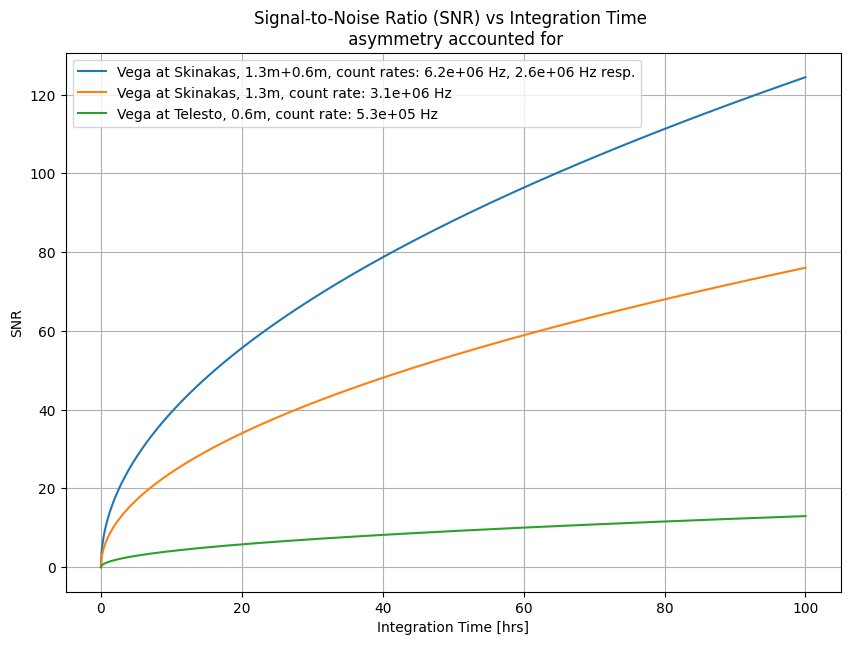

In [191]:
T_0 = np.linspace(0, 100, 1000)

mag = 0

diameter_1 = 1.21 # m
diameter_2 = 0.56 # m
diameter = 0.5 # m

# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 7))
snr_two_values = SNR_two(T_0, mag, diameter_1, diameter_2, efficiency_p_1=0.5, efficiency_p_2=1)
count_rate_2 = count_rate2(mag, diameter_1, efficiency_p=0.5)
count_rate_3 = count_rate2(mag, diameter_2)
plt.plot(T_0, snr_two_values, label=f"Vega at Skinakas, 1.3m+0.6m, count rates: {count_rate_2:.1e} Hz, {count_rate_3:.1e} Hz resp.")

# Plot for 1.3m telescope
snr_simple_1_values = SNR_simple(T_0, mag, diameter_1, efficiency_p=0.5)
count_rate_simple_1 = count_rate(mag, diameter_1, efficiency_p=0.5)
plt.plot(T_0, snr_simple_1_values, label=f"Vega at Skinakas, 1.3m, count rate: {count_rate_simple_1:.1e} Hz")


# Plot for 0.5m telescope
snr_simple_values = SNR_simple(T_0, mag, diameter, efficiency_p=0.5)
count_rate_simple = count_rate(mag, diameter, efficiency_p=0.5)
plt.plot(T_0, snr_simple_values, label=f"Vega at Telesto, 0.6m, count rate: {count_rate_simple:.1e} Hz")

plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) vs Integration Time \n asymmetry accounted for')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Skinakas Telescopes compared to Telesto for Vega

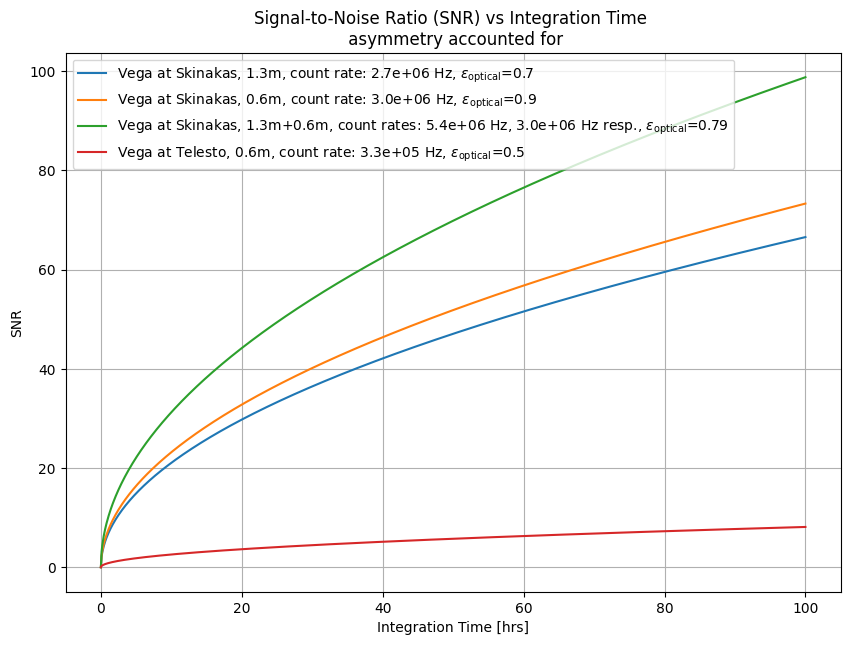

In [200]:
T_0 = np.linspace(0, 100, 1000)

mag = 0

diameter_1 = 1.21  # m
diameter_2 = 0.56  # m
diameter = 0.5  # m

# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 7))

# Plot for 1.3m+1.3m telescope, splitted on two SPADs, zero baseline
efficiency_o_skinakas_13m = 0.7
SNR_13m = SNR_simple(T_0, mag, diameter_1, efficiency_p=0.5, efficiency_o=efficiency_o_skinakas_13m)
count_rate_13m = count_rate(mag, diameter_1, efficiency_p=0.5, efficiency_o=efficiency_o_skinakas_13m)
plt.plot(T_0, SNR_13m, label=rf"Vega at Skinakas, 1.3m, count rate: {count_rate_13m:.1e} Hz, $\varepsilon_{{\text{{optical}}}}$={efficiency_o_skinakas_13m}")

# Plot for 0.6m telescope, single SPAD
efficiency_o_skinakas_06m = 0.9
SNR_06m = SNR_two(T_0, mag, diameter_2, diameter_2, efficiency_p_1=1, efficiency_p_2=1, efficiency_o_1=efficiency_o_skinakas_06m, efficiency_o_2=efficiency_o_skinakas_06m)
count_rate_06 = count_rate2(mag, diameter_2, efficiency_p=1, efficiency_o=efficiency_o_skinakas_06m)
plt.plot(T_0, SNR_06m, label=rf"Vega at Skinakas, 0.6m, count rate: {count_rate_06:.1e} Hz, $\varepsilon_{{\text{{optical}}}}$={efficiency_o_skinakas_06m}")

# Plot for 1.3m+0.6m
SNR_telescopes_combined = SNR_two(T_0, mag, diameter_1, diameter_2, efficiency_p_1=0.5, efficiency_p_2=1, efficiency_o_1=efficiency_o_skinakas_13m, efficiency_o_2=efficiency_o_skinakas_06m)
count_rate_bigger = count_rate2(mag, diameter_1, efficiency_p=0.5, efficiency_o=efficiency_o_skinakas_13m)
count_rate_smaller = count_rate2(mag, diameter_2, efficiency_p=1, efficiency_o=efficiency_o_skinakas_06m)
plt.plot(T_0, SNR_telescopes_combined, label=rf"Vega at Skinakas, 1.3m+0.6m, count rates: {count_rate_bigger:.1e} Hz, {count_rate_smaller:.1e} Hz resp., $\varepsilon_{{\text{{optical}}}}$={np.round(np.sqrt(efficiency_o_skinakas_13m*efficiency_o_skinakas_06m),2)}")

# Plot for 0.5m telescope Telesto
efficiency_o_telesto = 0.5
SNR_telesto = SNR_simple(T_0, mag, diameter, efficiency_p=0.5, efficiency_o=efficiency_o_telesto)
count_rate_telesto = count_rate(mag, diameter, efficiency_p=0.5, efficiency_o=efficiency_o_telesto)
plt.plot(T_0, SNR_telesto, label=rf"Vega at Telesto, 0.6m, count rate: {count_rate_telesto:.1e} Hz, $\varepsilon_{{\text{{optical}}}}$={efficiency_o_telesto}")

plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) vs Integration Time \n asymmetry accounted for')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [201]:
print(SNR_simple(6.5, mag, diameter_1, efficiency_p=0.5, efficiency_o=efficiency_o_skinakas_13m))
print(SNR_simple(6.5, mag, diameter_2, efficiency_p=1, efficiency_o=efficiency_o_skinakas_06m))
print(SNR_two(6.5, mag, diameter_1, diameter_2, efficiency_p_1=0.5, efficiency_p_2=1, efficiency_o_1=efficiency_o_skinakas_13m, efficiency_o_2=efficiency_o_skinakas_06m))


16.964228495978627
9.343592554577672
25.179899846439444


## C2PU Telescopes for Navi (Gam Cas)

In [ ]:
T_0 = np.linspace(0, 50, 1000)

mag = 2

diameter_1 = 1.03  # m
diameter_2 = 1.03  # m
diameter = 0.5  # m

# Plot SNR vs integration time T_0
plt.figure(figsize=(10, 7))


# Plot for 1.3m+1.3m telescope, splitted on two SPADs, zero baseline
SNR_1m = SNR_simple(T_0, mag, diameter_1, efficiency_p=0.5)
count_rate_1m = count_rate(mag, diameter_1, efficiency_p=0.5)
plt.plot(T_0, SNR_1m, label=f"Vega at Skinakas, 1m, 2SPADS, count rate: {count_rate_1m:.1e} Hz")

# Plot for 0.6m telescope, single SPAD
SNR_1m2 = SNR_two(T_0, mag, diameter_2, diameter_2, efficiency_p_1=1, efficiency_p_2=1)
count_rate_1m2 = count_rate2(mag, diameter_2, efficiency_p=1)
plt.plot(T_0, SNR_1m2, label=f"Vega at Skinakas, 1m, 1SPAD count rate: {count_rate_1m2:.1e} Hz")

# Plot for 0.5m telescope Telesto
SNR_telesto = SNR_simple(T_0, mag, diameter, efficiency_p=0.5)
count_rate_telesto = count_rate(mag, diameter, efficiency_p=0.5)
#plt.plot(T_0, SNR_telesto, label=f"Vega at Telesto, 0.6m, count rate: {count_rate_telesto:.1e} Hz")

plt.xlabel('Integration Time [hrs]')
plt.ylabel('SNR')
plt.title('Signal-to-Noise Ratio (SNR) vs Integration Time \n asymmetry accounted for')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
print(SNR_simple(1, 2, diameter=1.03, efficiency_p=0.5))
print(SNR_two(1, 2, 1.03, 1.03, efficiency_p_1=1, efficiency_p_2=1))
